# FIFA Game Result Prediction Using Linear and Logistic Regression




## 1. Defining the Question

### a) Specifying the Question

You have been recruited as a football analyst in a company - Mchezopesa Ltd and tasked to accomplish the task below.

Requirement
Predict home and away score arising from a game between team 1 and team 2.
Inputs are home team rank, away team ran, tournament type e.g World cup, Friendly, Other.

Classifiers to use are:
a) Polynomial Linear Regression

b) Logistic regression
Predict if game is a Win, Lose or Draw (W, L, D)


### b) Defining the Metric for Success

Prediction of home and away goals


### c) Understanding the context 

FIFA World Ranking is a ranking system for men's national teams in association football. The teams of member nations of FIFA, football's world governing body, are ranked based on their game results with the most successful teams being ranked highest. The rankings were introduced in December 1992

### d) Recording the Experimental Design

### e) Data Relevance

## 2. Importing the libraries

In [783]:
import pandas as pd #Data manipulation - import, merge etc
import numpy as np #Data manipulation - Linear algebra
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Import the libraries
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
from sklearn.metrics import confusion_matrix,mean_squared_error,accuracy_score
from sklearn.preprocessing import LabelEncoder #For categorical records conversion

In [409]:
# Increase rows visible
pd.set_option('display.max_rows', 5000)

## Reading the Data


In [410]:
# Loading the Dataset
df_ranking = pd.read_csv('fifa_ranking.csv',parse_dates=['rank_date'])
df_results = pd.read_csv('results.csv',parse_dates=['date'])

## 3. Checking the Data

a) Fifa Ranking and Results Exploration


In [411]:
# Determining the no. of records in our dataset
print("Fifa Ranking: ",df_ranking.shape)
print("Fifa Results: ",df_results.shape)

Fifa Ranking:  (57793, 16)
Fifa Results:  (40839, 9)


Observation: Records are date tracked meaning there are multiple instances of ranking and results records per country.

In [415]:
# Sample ranking records
df_ranking.sample(5)

,rank,country_full,country_abrv,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted,confederation,rank_date
22536,107,Malawi,MWI,0.00,436,-1,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,CAF,2004-03-17
46630,181,Mongolia,MNG,48.59,49,0,21.5,21.5,0.00,0.00,90.30,27.09,0.00,0.00,AFC,2014-01-16
31106,43,Tunisia,TUN,0.00,692,-6,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,CAF,2007-10-24
9054,167,Philippines,PHI,0.00,4,7,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,AFC,1998-07-15
41953,119,New Zealand,NZL,284.42,271,1,21.2,21.2,324.45,162.23,158.14,47.44,267.75,53.55,OFC,2012-03-07


In [416]:
# Sample results records
df_results.sample(5)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
8222,1972-06-28,Brazil,Czechoslovakia,0,0,Brazil Independence Cup,Rio de Janeiro,Brazil,False
5032,1961-12-04,Panama,Venezuela,2,6,Friendly,Barranquilla,Colombia,True
28915,2007-01-21,Saudi Arabia,Qatar,1,1,Gulf Cup,Abu Dhabi,United Arab Emirates,True
17625,1993-04-28,Thailand,Japan,0,1,FIFA World Cup qualification,Dubai,United Arab Emirates,True
27211,2004-12-19,Tanzania,Rwanda,1,5,CECAFA Cup,Addis Abeba,Ethiopia,True


In [420]:
#Describe results date
df_results['date'].describe()

count                   40839
unique                  15115
top       2012-02-29 00:00:00
freq                       66
first     1872-11-30 00:00:00
last      2019-07-20 00:00:00
Name: date, dtype: object

In [419]:
#Describe ranking date
df_ranking['rank_date'].describe()

count                   57793
unique                    286
top       2016-12-22 00:00:00
freq                      211
first     1993-08-08 00:00:00
last      2018-06-07 00:00:00
Name: rank_date, dtype: object

Observation: First date instance which has ranking is August 1993 against first results date of 1872.

### Drop Results Records older than 1993 as ranking started in Dec 1992.
Rationale: If the results do not have an associated ranking, they are not helpful in the prediction

In [421]:
# Drop the records
df_results.drop(df_results[df_results['date']<'1993-01-01'].sort_values(by ='date' ,ascending = False).index,inplace = True)
df_results.shape

(23478, 9)

In [422]:
#Drop records older than Dec 1992. Ranking result 1993-08-08
df_results[df_results['date']<'1993-01-01'].sort_values(by ='date' ,ascending = False)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral


### Identify countries in results but not ranking 

In [423]:
##DISTINCT Countries in results dataset
#Unique Home and Away
df_result_home_unique = df_results['home_team'].unique()
df_result_away_unique = df_results['away_team'].unique()
#Convert arrays to dataframes
df_result_home_unique = pd.DataFrame(df_result_home_unique)
df_result_away_unique = pd.DataFrame(df_result_away_unique)
#Merge the dataframes
frames = [df_result_home_unique,df_result_away_unique]
df_result_countries = pd.concat(frames)
#Drop duplicate countries
df_result_countries.drop_duplicates(inplace = True) 
df_result_countries.columns = ['Country']
print("Unique Countries in Results dataset: ",len(df_result_countries))

##DISTINCT countries in ranking dataset
df_ranking_unique = df_ranking['country_full'].unique()
df_ranking_unique = pd.DataFrame(df_ranking_unique)
df_ranking_unique.columns = ['Country']
print("Unique Countries in Ranking dataset: ",len(df_ranking_unique))


Unique Countries in Results dataset:  302
Unique Countries in Ranking dataset:  216


In [424]:
#Compare the two datasets
result_minus_ranking = df_result_countries[~df_result_countries.Country.isin(df_ranking_unique.Country.values)]
ranking_minus_result = df_ranking_unique[~df_ranking_unique.Country.isin(df_result_countries.Country.values)]
result_union_ranking = df_result_countries[df_result_countries.Country.isin(df_ranking_unique.Country.values)]
print("In result but not ranking: ",len(result_minus_ranking))
print("In ranking but not result: ",len(ranking_minus_result))
print("In ranking and result: ",len(result_union_ranking))

In result but not ranking:  106
In ranking but not result:  20
In ranking and result:  196


### a) Create a dataframe with relevant columns to answer the question

The Independent Variables are:
*   Home Team Rank
*   Away Team Rank
*   Tournament
*   Away Score
*   Home Score







In [425]:
#Dataframe with relevant columns
df = df_results[['date','home_team','away_team','home_score','away_score','tournament']]
df = df.copy()

In [170]:
df.head()

,date,home_team,away_team,home_score,away_score,tournament
17361,1993-01-01,Ghana,Mali,1,1,Friendly
17362,1993-01-02,Gabon,Burkina Faso,1,1,Friendly
17363,1993-01-02,Kuwait,Lebanon,2,0,Friendly
17364,1993-01-03,Burkina Faso,Mali,1,0,Friendly
17365,1993-01-03,Gabon,Ghana,2,3,Friendly


In [440]:
df_ranking[(df_ranking['country_full'] =='Ghana')& (df_ranking['rank_date'] <= '1994-01-01')]

,rank,country_full,country_abrv,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted,confederation,rank_date
47,48,Ghana,GHA,0.0,34,-9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CAF,1993-08-08
208,42,Ghana,GHA,0.0,33,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CAF,1993-09-23
373,40,Ghana,GHA,0.0,36,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CAF,1993-10-22
541,41,Ghana,GHA,0.0,36,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CAF,1993-11-19
705,37,Ghana,GHA,0.0,37,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CAF,1993-12-23


## 4. Feature Engineering

#### a) Home and Away Rank Columns

In [614]:
#Create a function to get rank of a country when given country and date
def getrank(country, rank_date):
    #Check country rankings lower than provided date
    df_rank = df_ranking[(df_ranking['country_full'] ==country)& (df_ranking['rank_date'] <= rank_date)]
    if len(df_rank) >0:                             
        #Get the latest rank date. Example. For 19th Jan, check last rank by Fifa
        df_rank = df_rank[df_rank['rank_date'] == df_rank['rank_date'].max()]
        #Retrieve the rank
        rank= df_rank.iloc[0,0] 
        return rank
    else:
        return -1

In [615]:
##Examples
getrank('Armenia','2014-05-31')

33

Procedure to loop through the rank dataframe and populate home and away

In [617]:
def populate_rank():
    #Blank list 
    home_rank = []
    away_rank = []
    for index, row in df.iterrows():
        home_rank.append(getrank(row['home_team'],row['date'])) 
        away_rank.append(getrank(row['away_team'],row['date'])) 
    #Create two new columns and append the values appended to the lists
    df["home_rank"] = home_rank
    df["away_rank"] = away_rank

In [437]:
#Execute the procedure 
populate_rank()

In [619]:
#Check populated ranks
df.sample()

,date,home_team,away_team,home_score,away_score,tournament,home_rank,away_rank,tournament_enc,year,month,day
19108,1995-09-03,Portugal,Northern Ireland,1,1,UEFA Euro qualification,9,55,57,1995,9,3


#### Drop the Records with -1. 
These are records where country ranking could not be retrieved due to incorrect country mapping. 
Better alternative could be cleanup the records using replace function. This activity not done due to time constraints


In [443]:
#Shape before dropping of records with no ranking
df.shape

(23478, 8)

In [620]:
#Drop values with -1 in both home and away rank columns
df = df[(df.home_rank != -1)]
df = df[(df.away_rank != -1)]

In [445]:
#Shape after dropping
df.shape

(18261, 8)

#### b) Split the date column into three variables

In [621]:
# Create new columns from year, month, day
df['year'] = df.date.dt.year
df['month'] = df.date.dt.month
df['day'] = df.date.dt.day

In [623]:
df.sample(3)

,date,home_team,away_team,home_score,away_score,tournament,home_rank,away_rank,tournament_enc,year,month,day
37989,2016-06-05,Papua New Guinea,Samoa,8,0,Oceania Nations Cup,193,168,45,2016,6,5
25565,2003-06-07,Seychelles,Zimbabwe,2,1,African Cup of Nations qualification,187,55,7,2003,6,7
23114,2000-07-16,Panama,Mexico,0,1,FIFA World Cup qualification,119,13,26,2000,7,16


#### c) Home Match Result : win , loss or draw

In [643]:
# Classify result as win , loss or draw from home team's perspective.
def categorize_result(home_score,away_score):
  outcome = ''
  goal_diff = home_score - away_score
  if goal_diff > 0:
    outcome = 'Win'
  elif goal_diff < 0:
    outcome = 'Loss'
  else:
    outcome = 'Draw'
  return outcome

# #Home outcome result
df['home_result_outcome'] = df.apply(lambda x: categorize_result(x['home_score'],x['away_score']),axis =1)

In [646]:
# Check Dataframe to verify the columns have been created
df.sample(4)

,date,home_team,away_team,home_score,away_score,tournament,home_rank,away_rank,tournament_enc,year,month,day,home_result_outcome
25241,2003-01-15,Nepal,Maldives,2,3,SAFF Cup,168,151,49,2003,1,15,Loss
22787,2000-04-22,Gabon,Madagascar,1,0,FIFA World Cup qualification,79,139,26,2000,4,22,Win
20731,1997-08-19,Greece,Cyprus,2,1,Friendly,40,84,27,1997,8,19,Win
37341,2015-10-10,Iceland,Latvia,2,2,UEFA Euro qualification,23,103,57,2015,10,10,Draw


## 4. External Data Source Validation

In [471]:
df.sample(5)

,date,home_team,away_team,home_score,away_score,tournament,home_rank,away_rank,tournament_enc,year,month,day
35085,2013-05-25,Malawi,Zimbabwe,1,1,Friendly,109,105,27,2013,5,25
35179,2013-06-10,Croatia,Portugal,0,1,Friendly,4,6,27,2013,6,10
38434,2016-11-11,Libya,Tunisia,0,1,FIFA World Cup qualification,76,38,26,2016,11,11
29383,2007-07-14,Mexico,Uruguay,3,1,Copa América,26,30,16,2007,7,14
23608,2001-02-27,Oman,Maldives,2,0,Friendly,107,154,27,2001,2,27


Making sure your data matches something outside of the dataset is very important. It allows you to ensure that the measurements are roughly in line with what they should be and it serves as a check on what other things might be wrong in your dataset. External validation can often be as simple as checking your data against a single number, as we will do here.

TEST 1: Sample above has Armenia as position 38 as at 2014-05-31, what was the actual rank then?

In [472]:
df_ranking[(df_ranking['country_full'] == 'Armenia')].sort_values(by = 'rank_date')

,rank,country_full,country_abrv,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted,confederation,rank_date
1671,159,Armenia,ARM,0.00,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,UEFA,1994-06-14
1844,159,Armenia,ARM,0.00,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,UEFA,1994-07-21
2000,142,Armenia,ARM,0.00,0,17,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,UEFA,1994-09-13
2172,141,Armenia,ARM,0.00,4,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,UEFA,1994-10-25
2347,141,Armenia,ARM,0.00,6,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,UEFA,1994-11-22
2525,141,Armenia,ARM,0.00,6,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,UEFA,1994-12-20
2708,144,Armenia,ARM,0.00,6,-3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,UEFA,1995-02-20
2887,144,Armenia,ARM,0.00,6,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,UEFA,1995-04-19
3055,133,Armenia,ARM,0.00,6,11,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,UEFA,1995-05-16
3229,128,Armenia,ARM,0.00,8,5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,UEFA,1995-06-13


Outcome:
By crosschecking mapped rank against original dataset, the rank is consistent with actual rank then.
    

## 5. Tidying the Dataset

a) Ranking


UFuncTypeError: ufunc 'add' cannot use operands with types dtype('<M8[ns]') and dtype('<M8[ns]')

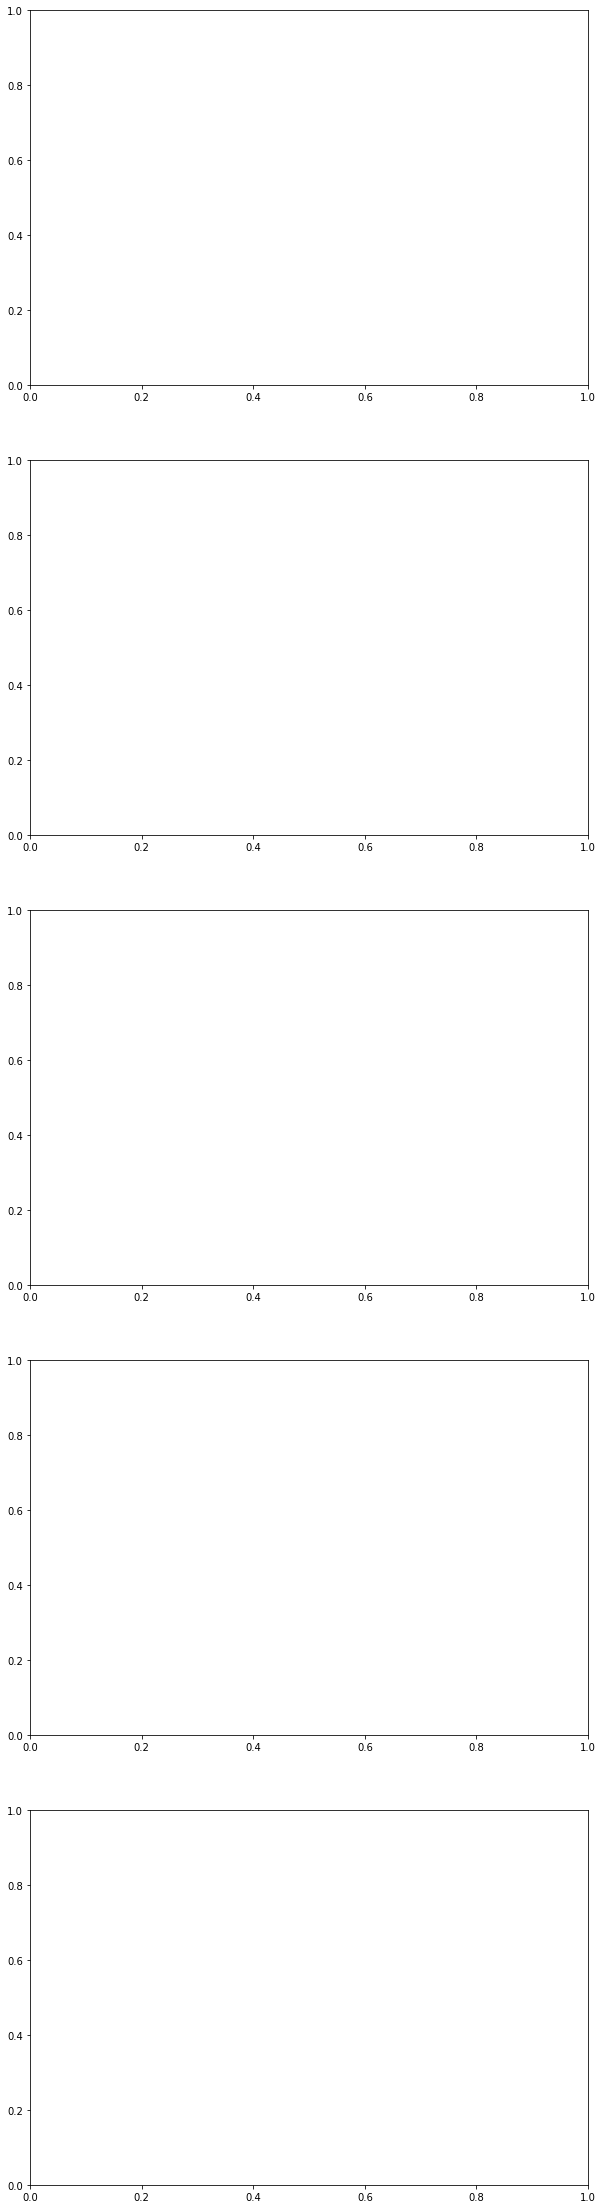

In [448]:
# Checking for Outliers
#Outlier: 
col_names = numeric_clmns = df.dtypes[df.dtypes != "object"].index

fig, ax = plt.subplots(len(col_names), figsize=(10,40))

for i, col_val in enumerate(col_names):

    sns.boxplot(y=df[col_val], ax=ax[i])
    ax[i].set_title('Box plot - {}'.format(col_val), fontsize=10)
    ax[i].set_xlabel(col_val, fontsize=8)

plt.tight_layout()
plt.show()

In [473]:
# Checking for Anomalies
df.duplicated().sum()

0

In [474]:
# Identifying the Missing Data
df.isnull().sum()

date              0
home_team         0
away_team         0
home_score        0
away_score        0
tournament        0
home_rank         0
away_rank         0
tournament_enc    0
year              0
month             0
day               0
dtype: int64

In [0]:
# Dealing with the Missing Data
#No action to perform.

In [0]:
# More data cleaning procedures


b) Results


## 6. Exploratory Analysis
Ploting the univariate summaries and recording our observations

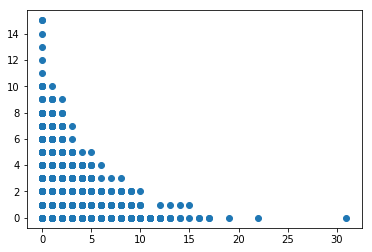

In [475]:
# home score versus away score
plt.scatter(df['home_score'],df['away_score'])
plt.show()

## 7. Modelling

### 7.1 Predict Home Score
#### Method 1: Using Polynomial Linear Regression: Predict Home Result

a) Convert Categorical variables to numerical variables. Tournament used during polynomial regression and home result outcome used in calculation of logistic regression result

In [806]:
# Instantiate label encoder object
le = LabelEncoder()
df['tournament'] = le.fit_transform(df['tournament'])
df['home_result_outcome'] = le.fit_transform(df['home_result_outcome'])

b) Home Result prediction

In [814]:
#Dependent variables are
df.iloc[:,[4,5,6,7,9]].sample(5)

,away_score,tournament,home_rank,away_rank,year
37233,0,57,9,46,2015
35669,0,27,57,31,2013
28480,4,2,153,85,2006
26972,1,26,68,37,2004
23420,2,27,20,74,2000


In [812]:
#Split X and Y dataset
X = df.iloc[:,[4,5,6,7,9]].values
y = df.iloc[:, 3].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.6, random_state = 42)

# Scale the training and test dataset
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Fitting the polynomial features to the X_train and X_test
poly_features = PolynomialFeatures(degree = 2,include_bias = False)
X_train = poly_features.fit_transform(X_train)
X_test = poly_features.fit_transform(X_test)

#Instantiate and Train the model
pol_reg = LinearRegression()
pol_reg.fit(X_train, y_train)

#Predict
y_predict = pol_reg.predict(X_test)

df_pred = pd.DataFrame({'y_predict': y_predict, 'y_test': y_test})

print(df_pred.sample(5))

#Print the results
rmse_value =  np.sqrt(metrics.mean_squared_error(y_test, y_predict))
print(" The Root Mean Square Score is ",rmse_value)

      y_predict  y_test
1374   0.477921       0
1433   1.336700       1
3525   2.126047       0
7589   3.714513       1
9838   1.156942       1
 The Root Mean Square Score is  1.4491062877898866


/home/ken/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### Logistic Regression

In [798]:
#Correlation between variables
df.corr()

,home_score,away_score,tournament,home_rank,away_rank,tournament_enc,year,month,day,home_result_outcome
home_score,1.000000,-0.165712,-0.010695,-0.123277,0.301964,-0.010695,-0.038862,0.014740,-0.007816,0.519418
away_score,-0.165712,1.000000,0.027658,0.209972,-0.160241,0.027658,-0.006063,0.016411,-0.023550,-0.241560
tournament,-0.010695,0.027658,1.000000,-0.148833,-0.152602,1.000000,-0.031117,0.095028,-0.051541,-0.001830
home_rank,-0.123277,0.209972,-0.148833,1.000000,0.484320,-0.148833,0.103014,0.036946,-0.003372,-0.101817
away_rank,0.301964,-0.160241,-0.152602,0.484320,1.000000,-0.152602,0.106252,0.035339,0.012312,0.197218
tournament_enc,-0.010695,0.027658,1.000000,-0.148833,-0.152602,1.000000,-0.031117,0.095028,-0.051541,-0.001830
year,-0.038862,-0.006063,-0.031117,0.103014,0.106252,-0.031117,1.000000,0.045828,-0.035160,-0.016489
month,0.014740,0.016411,0.095028,0.036946,0.035339,0.095028,0.045828,1.000000,-0.241903,0.009915
day,-0.007816,-0.023550,-0.051541,-0.003372,0.012312,-0.051541,-0.035160,-0.241903,1.000000,-0.010773
home_result_outcome,0.519418,-0.241560,-0.001830,-0.101817,0.197218,-0.001830,-0.016489,0.009915,-0.010773,1.000000


Logistic Regression Calculation

In [796]:
# Split independent and dependent variables
X = df.iloc[:,[3,5,6,7,9,10]].values
y = df.home_result_outcome


# Split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Intanstiate and train the Logistic Regression model
logistic = LogisticRegression()
logistic.fit(X_train, y_train)

# Predict the dependent variable from x test set
y_pred = logistic.predict(X_test)

# Measuring the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print('The accuracy of the model is', accuracy)
print("Confusion matrix is as below")
confusion_matrix(y_test, y_pred)

The accuracy of the model is 0.6676400803066252
Confusion matrix is as below


array([[ 128,  672,  544],
       [ 115, 1119,  262],
       [  37,  191, 2411]])

## 8. Challenging the solution

> The easy solution is nice because it is, well, easy, but you should never allow those results to hold the day. You should always be thinking of ways to challenge the results, especially if those results comport with your prior expectation.






In [0]:
# Reviewing the Solution 
#

## 9. Follow up questions

> At this point, we can refine our question or collect new data, all in an iterative process to get at the truth.



### a). Did we have the right data?

### b). Do we need other data to answer our question?

### c). Did we have the right question?